In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import bar_chart_race as bcr

from datetime import datetime
from pytz import timezone
import plotly.express as px



In [2]:
data_dir = '/Users/Karolina/ProjectsDataScience/data_science_environment/data/'
file_list = ['MyDataSpotify/StreamingHistory0.json',
             'MyDataSpotify/StreamingHistory1.json',
             'MyDataSpotify/StreamingHistory2.json',
             'MyDataSpotify/StreamingHistory3.json',
             'MyDataSpotify/StreamingHistory4.json',
             'MyDataSpotify/StreamingHistory5.json',
             'MyDataSpotify/StreamingHistory6.json']

dfs = [] # an empty list to store the data frames
for file in file_list:
    data = pd.read_json(data_dir+file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.

In [3]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-11-21 08:21,"Does It Offend You, Yeah?",We Are Rockstars,13744
1,2020-11-21 08:25,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170
2,2020-11-21 08:27,"Does It Offend You, Yeah?",We Are Rockstars,69343
3,2020-11-21 08:30,"Does It Offend You, Yeah?",Doomed Now,221133
4,2020-11-21 08:31,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63060 entries, 0 to 63059
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     63060 non-null  object
 1   artistName  63060 non-null  object
 2   trackName   63060 non-null  object
 3   msPlayed    63060 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [5]:
#double checking for duplicates
df.duplicated().sum()

4007

In [6]:
# remove duplicates
df.drop_duplicates(inplace=True)

# double checking for duplicates
df.duplicated().sum()

0

In [7]:
df.endTime = pd.to_datetime(df.endTime, infer_datetime_format=True) 

In [8]:
#Set the current time to US Pacific timezone
df['endTimeTz']= df.endTime.dt.tz_localize(tz='UTC')

#convert US Pacific to Europe/Berlin Timezone
df['endTimeTzEU']=df.endTimeTz.dt.tz_convert(tz='Europe/Berlin')

df['hour'] = df.endTimeTzEU.dt.hour
df['date'] = df['endTime'].dt.to_period('D').apply(lambda r: r.start_time)
df['week'] = df['endTime'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['endTimeTzEU'].dt.to_period('M').apply(lambda r: r.start_time)


df['sPlayed'] = df['msPlayed']/(1000)
df['mPlayed'] = df['sPlayed']/(60)
df['hPlayed'] = df['sPlayed']/(60*60)


df['id'] = df['trackName']

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59053 entries, 0 to 63059
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype                        
---  ------       --------------  -----                        
 0   endTime      59053 non-null  datetime64[ns]               
 1   artistName   59053 non-null  object                       
 2   trackName    59053 non-null  object                       
 3   msPlayed     59053 non-null  int64                        
 4   endTimeTz    59053 non-null  datetime64[ns, UTC]          
 5   endTimeTzEU  59053 non-null  datetime64[ns, Europe/Berlin]
 6   hour         59053 non-null  int64                        
 7   date         59053 non-null  datetime64[ns]               
 8   week         59053 non-null  datetime64[ns]               
 9   month        59053 non-null  datetime64[ns]               
 10  sPlayed      59053 non-null  float64                      
 11  mPlayed      59053 non-null  float64                  

In [10]:
# based on number of streams

df_no_skips = df.loc[df['sPlayed']>10]

weekly = df_no_skips.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['trackName'].size().reset_index()
weekly['no_csum'] = weekly.groupby(['artistName'])['trackName'].cumsum()


#choosing only top5 artist in a given week
weekly5 = weekly.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(5)

#reformatting the data into format suitable for the bar_chart_race package
weekly5_u = weekly5.unstack()
weekly5_u.fillna(method='ffill', inplace=True)
weekly5_u.fillna(0, inplace=True)

In [11]:
# based on msPlayed

df_no_skips = df.loc[df['sPlayed']>10]

weekly_time = df_no_skips.groupby([pd.Grouper(key='endTime', freq='W'),'artistName'])['msPlayed'].sum().reset_index()
weekly_time['no_csum'] = weekly_time.groupby(['artistName'])['msPlayed'].cumsum()

#weekly_time = weekly_time.loc[weekly_time['artistName']!= 'Justin Bieber']


#choosing only top5 artist in a given week
weekly_time5 = weekly_time.set_index(['endTime', 'artistName']).groupby(level=0, group_keys=False)['no_csum'].nlargest(10)

#reformatting the data into format suitable for the bar_chart_race package
weekly_time5_u = weekly_time5.unstack()
weekly_time5_u.fillna(method='ffill', inplace=True)
weekly_time5_u.fillna(0, inplace=True)

CPU times: user 1min 13s, sys: 10.9 s, total: 1min 24s
Wall time: 1min 27s


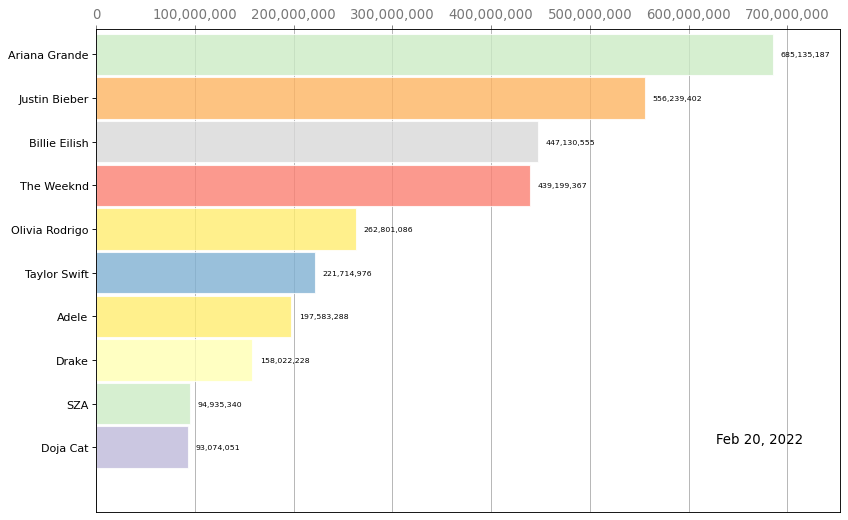

In [12]:
%%time
# help(bcr.bar_chart_race)

#initiate fig
fig, ax = plt.subplots(figsize=(12,8), facecolor='white', dpi= 80)

ax.margins(0, 0.01)
ax.set_axisbelow(True)

#ticks
ax.grid(which='major', axis='x', linestyle='-')
ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')


bcr.bar_chart_race(df=weekly_time5_u, 
                   n_bars=10, 
                   fig=fig, 
                   period_length=400, 
                   cmap='Set3_r',
                   period_fmt='%b %-d, %Y',
                   title='The most listened artists in 2021', 
                   title_size='smaller',
                   filter_column_colors=True)

In [13]:
weekly_time.loc[weekly_time['artistName']!= 'Justin Bieber']

,endTime,artistName,msPlayed,no_csum
0,2021-01-24,AaRON,255453,255453
1,2021-01-24,Academy Chamber Choir,484453,484453
2,2021-01-24,Alexandra Steliski,170156,170156
3,2021-01-24,Andy Stringer,4477,4477
4,2021-01-24,Arden Forest,113909,113909
...,...,...,...,...
7932,2021-11-21,Travis Scott,692012,8430059
7933,2021-11-21,Two Feet,83302,16545811
7934,2021-11-21,Tyga,232932,8965742
7935,2021-11-21,Unknown Mortal Orchestra,22203,252350


In [20]:
help(bcr.bar_chart_race)

Help on function bar_chart_race in module bar_chart_race._make_chart:

bar_chart_race(df, filename=None, orientation='h', sort='desc', n_bars=None, fixed_order=False, fixed_max=False, steps_per_period=10, period_length=500, interpolate_period=False, label_bars=True, bar_size=0.95, period_label=True, period_fmt=None, period_summary_func=None, perpendicular_bar_func=None, figsize=(6, 3.5), cmap=None, title=None, title_size=None, bar_label_size=7, tick_label_size=7, shared_fontdict=None, scale='linear', writer=None, fig=None, dpi=144, bar_kwargs=None, filter_column_colors=False)
    Create an animated bar chart race using matplotlib. Data must be in 
    'wide' format where each row represents a single time period and each 
    column represents a distinct category. Optionally, the index can label 
    the time period.
    
    Bar height and location change linearly from one time period to the next.
    
    If no `filename` is given, an HTML string is returned, otherwise the 
    animat

In [13]:
test = weekly_time5_u[43:]

In [14]:
x = test.transpose().reset_index()

In [52]:
x.columns=[ 'artistName', 'nr']
x.sort_values(by='nr', ascending=True, inplace=True)
x

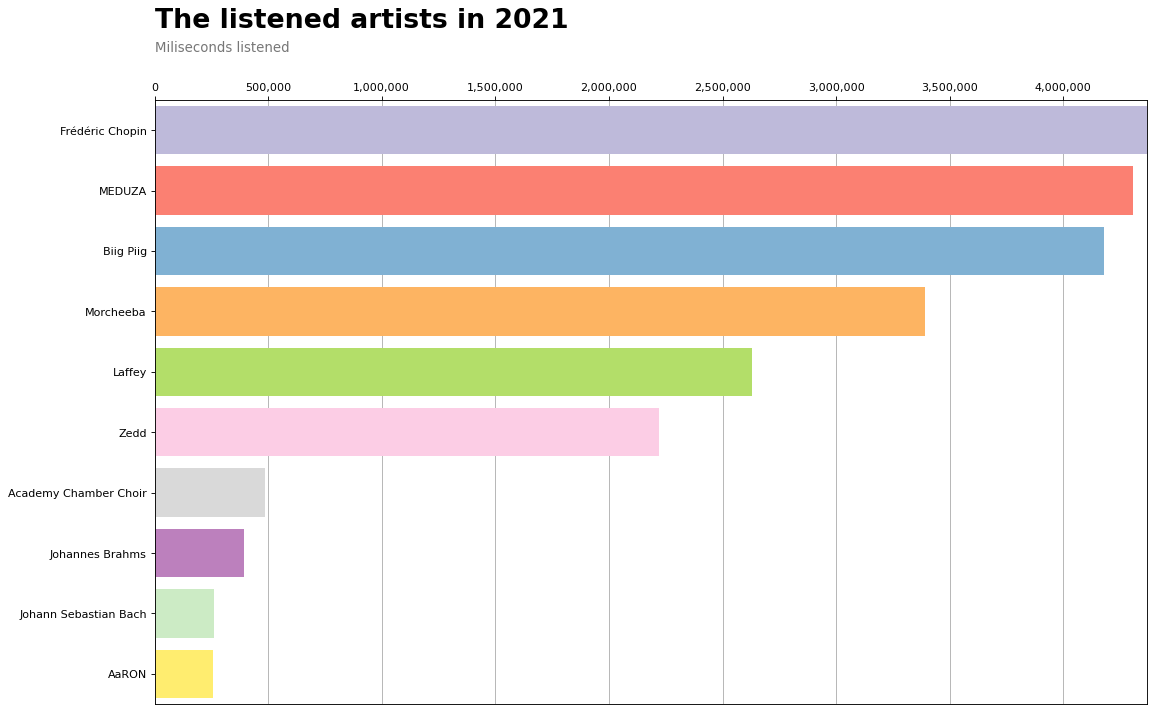

In [58]:
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
my_cmap = plt.get_cmap("Set3_r")

ax.barh(x['artistName'], x['nr'], color=my_cmap.colors)

ax.margins(0, 0.01)
ax.set_axisbelow(True)

#ticks
ax.grid(which='major', axis='x', linestyle='-')
#ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks_position('top')

#text
ax.text(0, 1.12, 'The listened artists in 2021',
            transform=ax.transAxes, size=24, weight=600, ha='left')
ax.text(0, 1.08, 'Miliseconds listened', transform=ax.transAxes, size=12, color='#777777')


plt.show()